In [279]:
%load_ext autoreload
%autoreload 2
import pylab as pl
import numpy as np 
import camb 
from tqdm import tqdm

import lensit as li
from lensit.clusterlens import lensingmap, profile

from lensit.misc.misc_utils import gauss_beam, pp_to_kk
from lensit.ffs_covs import ffs_cov, ell_mat

import plancklens
import healpy as hp
from plancklens import qresp
from plancklens import utils
from plancklens.utils import cli
from plancklens.wigners import wigners
from plancklens import n0s

import os
import os.path as op
import matplotlib as mpl
from matplotlib import pyplot as plt

from scipy.interpolate import UnivariateSpline as spline

mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['font.size'] = 20
mpl.rcParams['figure.figsize'] = 15, 12
mpl.rc('xtick', labelsize=23) 
mpl.rc('ytick', labelsize=23) 


mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['mathtext.rm'] = 'serif'
mpl.rc('text', usetex=True)
mpl.rcParams['errorbar.capsize'] = 4
mpl.rc('legend', fontsize=15)
mpl.rcParams.update(mpl.rcParamsDefault)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [280]:
# We start by intiating CAMB which will give us the relevant cosmology 
cambinifile = 'planck_2018_acc'
#pars = camb.read_ini(op.join(op.dirname(camb.__path__[0]),  'inifiles', cambinifile + '.ini'))
pars = camb.read_ini(op.join(op.dirname('/Users/sayan/CMB_WORK/CAMB-1.1.3/inifiles'),  'inifiles', cambinifile + '.ini'))
results = camb.get_results(pars)

In [281]:
# We define here the parameters for the profile of the cluster
M200= 2*1e14
z = 0.7
profname = 'nfw'
# profparams={'M200c':M200, 'z':z}

# Set CMB experiment for noise level and beam
# cmb_exp='S4_opti'
# cmb_exp='S4_opti'
# nlev_t, nlev_p, beam_fwhm_amin, lmin_cmb, lmax_cmb = li.get_config(cmb_exp)

cmb_exp='S4_opti' # S4_opti config
# cmb_exp='S4_opti_6000' # S4_opti config up to 6000

# cmb_exp='Planck45' # Planck Z and C config up to 2048
# cmb_exp='Planck45_lmax3000' # Planck Z and C config up to 3000

nlev_t, nlev_p, beam_fwhm_amin, lmin_cmb, lmax_cmb = li.get_config(cmb_exp)
lmax_cmb=5000
lmin_cmb=1000
nlev_t = np.array([0.1,0.5,1,3,5,7])
nlev_p = nlev_t*np.sqrt(2)
names = {'S4_opti':'S4, lmax=3000', 'S4_opti_6000':'S4, lmax=6000',
        'Planck45':'Planck, lmax=2048', 'Planck45_lmax3000':'Planck, lmax=3000' }

# nlev_t = 45.
# nlev_p = 45*np.sqrt(2)
# beam_fwhm_amin = 5
# lmin_cmb = 10
# lmax_cmb = 3000


hprofile = profile.profile(results, profname)

In [282]:
lmax = 8000
ell = np.arange(lmax+1)

cpp_fid = results.get_lens_potential_cls(lmax=lmax, raw_cl=True).T[0]

camb_cls = results.get_unlensed_scalar_cls(CMB_unit='muK', raw_cl=True, lmax=lmax).T
cls_unl_fid = {'tt':camb_cls[0], 'ee':camb_cls[1], 'bb':camb_cls[2], 'te':camb_cls[3], 'pp':cpp_fid}

camb_cls_len = results.get_lensed_scalar_cls(CMB_unit='muK', raw_cl=True, lmax=lmax).T
cls_len_fid = {'tt':camb_cls_len[0], 'ee':camb_cls_len[1], 'bb':camb_cls_len[2], 'te':camb_cls_len[3], 'pp':cpp_fid}

thmax in amin, thscale 2.139100514187885 0.6846534736764758


/Users/sayan/Project_Geneva/Carron_codes/LensIt-master-3/lensit/clusterlens/profile.py:181: RuntimeWarning: invalid value encountered in subtract
  Cidiff = Cixpc - Cix
/Users/sayan/Project_Geneva/Carron_codes/LensIt-master-3/lensit/clusterlens/profile.py:182: RuntimeWarning: invalid value encountered in true_divide
  u0 = np.sin(x) * Sidiff + np.cos(x) * Cidiff - np.sin(x * c) / (x * (1. + c))


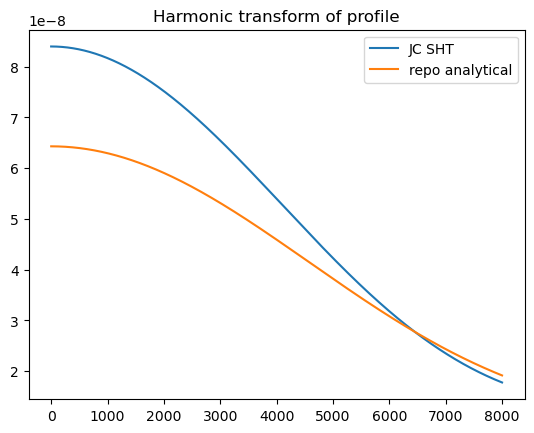

In [283]:
ft_analytical = hprofile.analitic_kappa_ft(M200, z, ell)

R_200 = hprofile.get_r200(M200, z)
R_s = hprofile.get_rs(M200,z)
thtscale = hprofile.r_to_theta(z, R_s)
thtmax = hprofile.r_to_theta(z, R_200)
#thtmax = hprofile.x_to_theta_amin(M200, z, xmax)
#thtscale = hprofile.x_to_theta_amin(M200, z, 1.)

print('thmax in amin, thscale', thtmax, thtscale)
xg, wg = wigners.get_xgwg(np.cos(thtmax / 180 / 60 * np.pi),1., max(5000, int(lmax * thtmax / (360 * 60))))
kappa = hprofile.kappa_theta(M200, 1., np.arccos(xg) / np.pi * 180 * 60 )
kappa_l = wigners.wignercoeff(kappa * wg, xg, 0, 0, lmax) 
kappa_0 = hprofile.kappa_theta(M200, z, thtscale *(1.001) )[0]
#ft_analytical = hprofile.analitic_kappa_ft(M200,z, np.arange(lmax + 1))
pl.title('Harmonic transform of profile')
pl.plot(kappa_l, label='JC SHT')
pl.plot(ft_analytical, label='repo analytical')
pl.legend()

In [285]:
## Details for the evaluation
lmin_ivf, lmax_ivf, lmax_qlm = 1000, 5000, lmax
transf = hp.gauss_beam(1. / 180 / 60 * np.pi, lmax=lmax_ivf)
nlevt = 1
#kSZ_Dl = 0
kSZ_Dl = 2.9
wCkk = True
k, ksource = 'ptt', 'p'
kSZ_Cl = kSZ_Dl * utils.cli(np.arange(lmax_ivf + 1) * np.arange(1, lmax_ivf + 2) / 2 / np.pi)
################

cls_path = os.path.join(os.path.dirname(os.path.abspath(plancklens.__file__)), 'data', 'cls')
cls_len = cls_len_fid
cls_unl = cls_unl_fid
cls_weight = cls_len_fid

fals = {'tt': cli(cls_len['tt'][:lmax_ivf + 1] + (nlevt / 180 / 60 * np.pi) ** 2 / transf ** 2) + kSZ_Cl / transf ** 2}
fals['tt'][:lmin_ivf] *= 0.
fals['ee'] = cli(cls_len['ee'][:lmax_ivf + 1] + (nlevt * np.sqrt(2.) / 180 / 60 * np.pi) ** 2 / transf ** 2)
fals['ee'][:lmin_ivf] *= 0.
fals['bb'] = cli(cls_len['bb'][:lmax_ivf + 1] + (nlevt * np.sqrt(2.) / 180 / 60 * np.pi) ** 2 / transf ** 2)
fals['bb'][:lmin_ivf] *= 0.

N0_pp = utils.cli(qresp.get_response(k, lmax_ivf, ksource, cls_weight, cls_len, fals, lmax_qlm=lmax_qlm)[0])
N0_pp +=  wCkk*cls_unl['pp'][:lmax_qlm+1]
#N0_kk = N0_pp[ell] * pp_to_kk(ell)
N0_kk_1 = N0_pp[ell] * pp_to_kk(ell)

#N0s, N0s_curl = n0s.get_N0(beam_fwhm=1, nlev_t=nlevt, nlev_p=nlevt*np.sqrt(2), lmax_CMB=lmax_ivf, lmin_CMB=lmin_ivf, lmax_out=lmax_qlm, cls_len=cls_len_fid, cls_weight=cls_len_fid)

NL = {}
NL['ptt'] = N0s['ptt'] + cpp_fid
NL_final = NL["ptt"][ell]*pp_to_kk(ell)

Text(0.5, 1.0, 'Difference in $N_0$ after adding $D^{KSz} = 2.9\\mu K^2$ ')

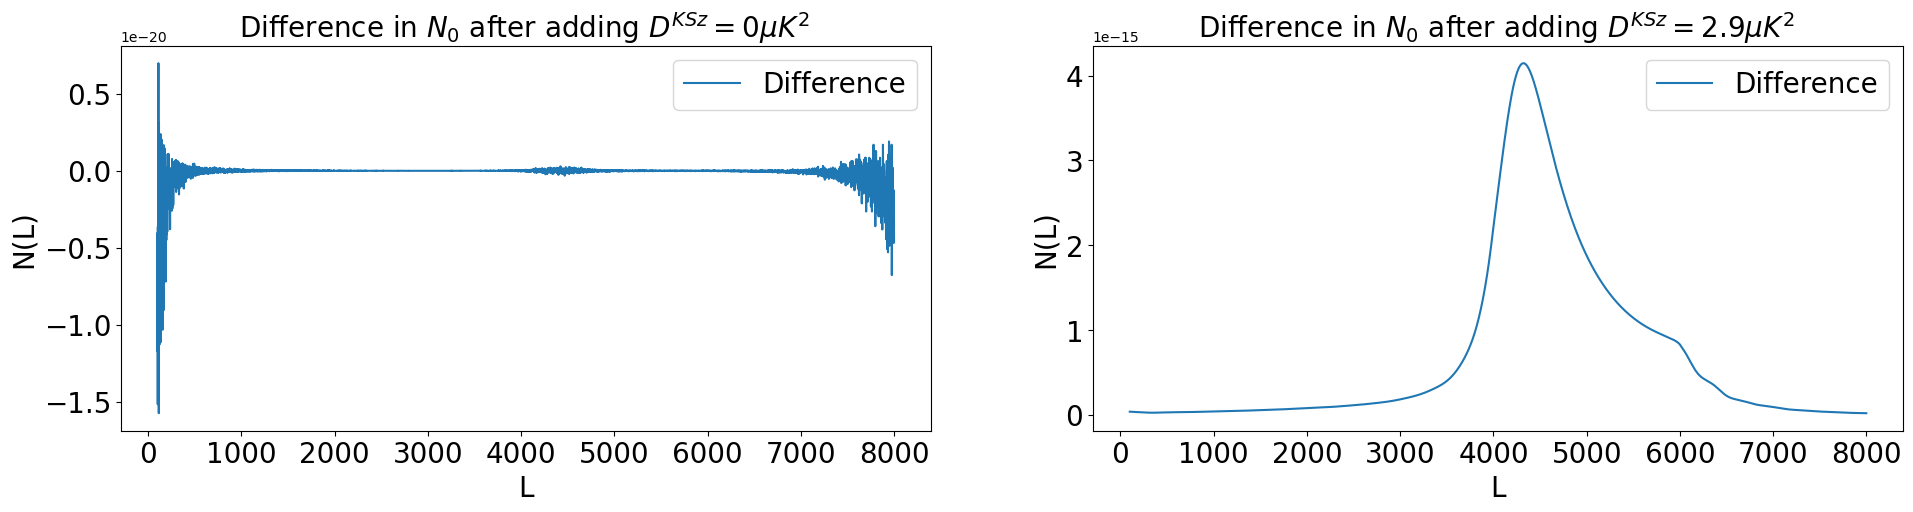

In [289]:
n=100
m=-1
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(23,5))
ax[0].plot(ell[n:m], NL_final[n:m]-N0_kk[n:m], label='Difference')
ax[0].tick_params(axis='both', which='major', labelsize=20)
ax[0].set_xlabel('L', fontsize=20)
ax[0].set_ylabel('N(L)', fontsize=20)
ax[0].legend(fontsize=20)
ax[0].set_title(r"Difference in $N_0$ after adding $D^{KSz} = 0\mu K^2$ ", fontsize=20)

ax[1].plot(ell[n:m], NL_final[n:m]-N0_kk_1[n:m], label='Difference')
ax[1].tick_params(axis='both', which='major', labelsize=20)
ax[1].set_xlabel('L', fontsize=20)
ax[1].set_ylabel('N(L)', fontsize=20)
ax[1].legend(fontsize=20)
ax[1].set_title(r"Difference in $N_0$ after adding $D^{KSz} = 2.9\mu K^2$ ", fontsize=20)

# Difference between flat sky and curved sky integrand
## FS Integrand $=\frac{L}{2\pi}  \frac{ |\kappa^t_L|^2 }{N_L}$, CS Integrand $=\left(\frac{2L + 1}{4\pi} \right)\frac{ |\kappa^t_L|^2 }{N_L}$

Text(0.5, 0.98, 'FS Integrand $=\\frac{L}{2\\pi}  \\frac{ |\\kappa^t_L|^2 }{N_L}$, CS Integrand $=\\left(\\frac{2L + 1}{4\\pi} \\right)\\frac{ |\\kappa^t_L|^2 }{N_L}$')

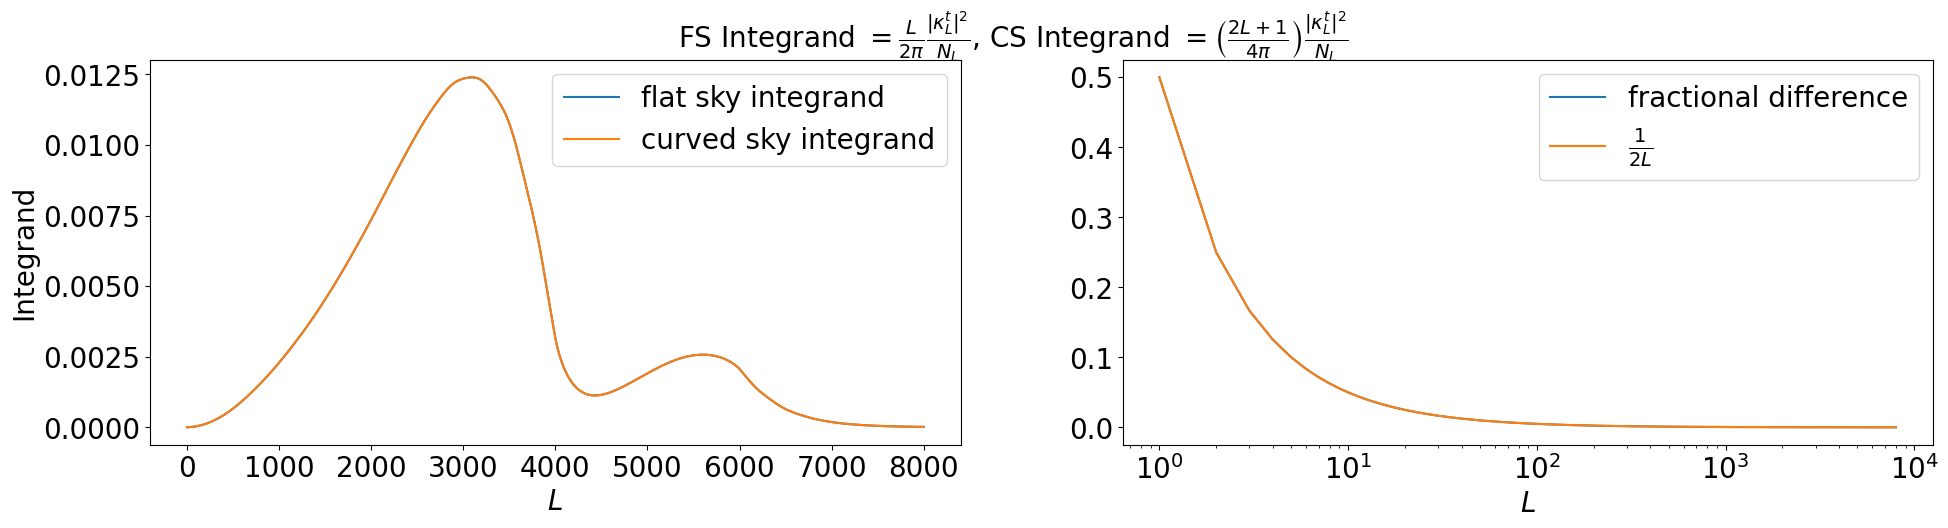

In [290]:
ell = np.arange(1,lmax+1)
kappa_ell = kappa_l[ell]
snr_tt = ell*(kappa_ell/kappa0)**2/(NL["ptt"][ell]*pp_to_kk(ell))/(2*np.pi)
snr_tt1 = (2*ell + 1)*(kappa_ell/kappa0)**2/(NL["ptt"][ell]*pp_to_kk(ell))/(4 * np.pi)

fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(23,5))
ax[0].tick_params(axis='both', which='major', labelsize=20)
#plt.plot(ell, (snr_tt1-snr_tt)/snr_tt, label="MV it with lmin=10")
#plt.plot(ell, 1/2/ell)
#plt.plot(ell, (snr_tt1-snr_tt), label="MV it with lmin=10")
ax[0].plot(ell, snr_tt, label="flat sky integrand")
ax[0].plot(ell, snr_tt1, label="curved sky integrand")
#plt.yscale("log")
ax[0].set_xlabel(r'$L$', fontsize=20)
ax[0].set_ylabel(r'Integrand', fontsize=20)
ax[0].legend(fontsize=20)


ax[1].plot(ell, (snr_tt1-snr_tt)/snr_tt, label="fractional difference")
ax[1].plot(ell, 1/2/ell, label=r"$\frac{1}{2L}$")
ax[1].set_xscale("log")
#ax[1].set_yscale("log")
ax[1].set_xlabel(r'$L$', fontsize=20)
ax[1].tick_params(axis='both', which='major', labelsize=20)
#ax[1].set_ylabel(r'$L \kappa_L^2 / N_L$')
ax[1].legend(fontsize=20)

fig.suptitle(r'FS Integrand $=\frac{L}{2\pi}  \frac{ |\kappa^t_L|^2 }{N_L}$, CS Integrand $=\left(\frac{2L + 1}{4\pi} \right)\frac{ |\kappa^t_L|^2 }{N_L}$', fontsize=20)

The difference between the curved sky integrand and flat sky integrand is $\frac{1}{4\pi}\frac{|\kappa_L^t|^2}{N_L}$

# Differnce between the integrands using Numerical FT & Analytical FT

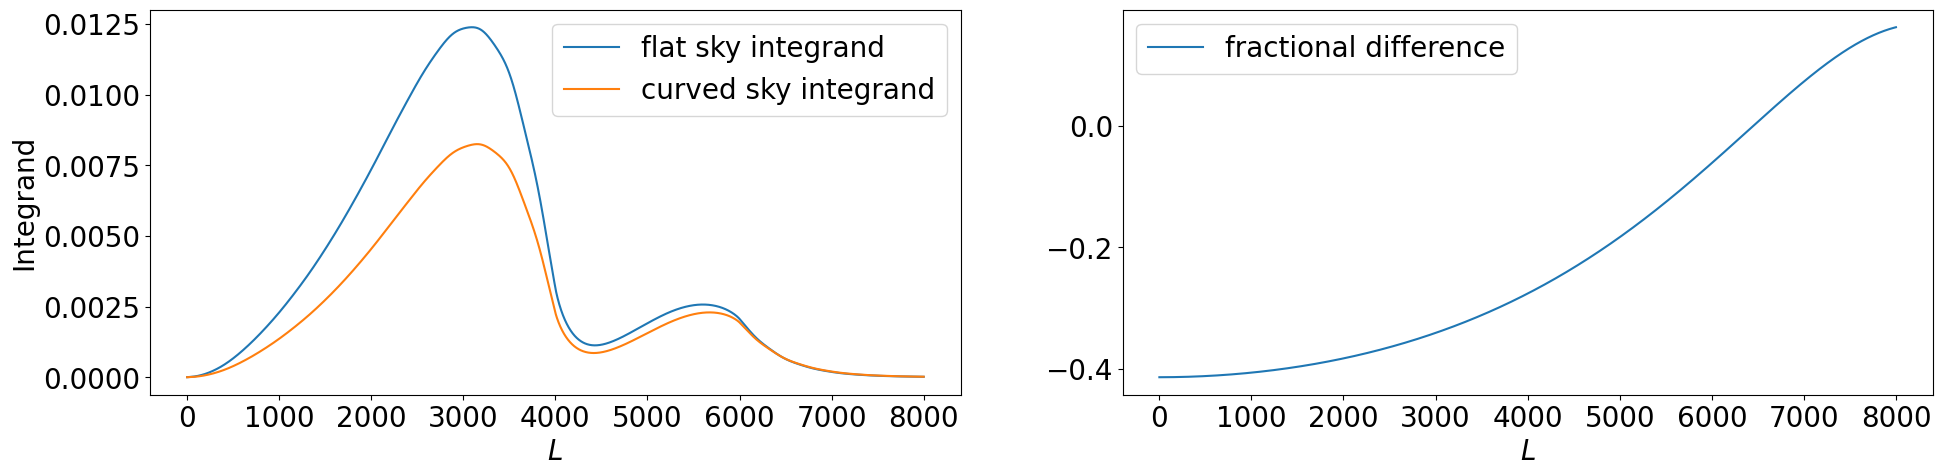

In [291]:
ell = np.arange(1,lmax+1)
kappa_ell = kappa_l[ell]
kappa_anal = ft_analytical[ell]

snr_tt = ell*(kappa_ell/kappa0)**2/(NL["ptt"][ell]*pp_to_kk(ell))/(2*np.pi)
snr_tt1 = ell*(kappa_anal/kappa0)**2/(NL["ptt"][ell]*pp_to_kk(ell))/(2*np.pi)

fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(23,5))
ax[0].tick_params(axis='both', which='major', labelsize=20)
#plt.plot(ell, (snr_tt1-snr_tt)/snr_tt, label="MV it with lmin=10")
#plt.plot(ell, 1/2/ell)
#plt.plot(ell, (snr_tt1-snr_tt), label="MV it with lmin=10")
ax[0].plot(ell, snr_tt, label="flat sky integrand")
ax[0].plot(ell, snr_tt1, label="curved sky integrand")
#plt.yscale("log")
ax[0].set_xlabel(r'$L$', fontsize=20)
ax[0].set_ylabel(r'Integrand', fontsize=20)
ax[0].legend(fontsize=20)


ax[1].plot(ell, (snr_tt1-snr_tt)/snr_tt, label="fractional difference")
#ax[1].set_xscale("log")
#ax[1].set_yscale("log")
ax[1].set_xlabel(r'$L$', fontsize=20)
ax[1].tick_params(axis='both', which='major', labelsize=20)
#ax[1].set_ylabel(r'$L \kappa_L^2 / N_L$')
ax[1].legend(fontsize=20)

# Difference between np.sum() and np.trapz()



In [292]:
k = 'ptt'
itmax = 10
N_clusters = 100000
M200= 2*1e14
z = 0.7
kappa0 = haloprofile.get_kappa0(M200, z)
#nlev_t = np.array([1,2,3,4,5])
nlev_t = np.array([0.1,0.5,1,3,5,7])
nlev_p = nlev_t*np.sqrt(2)
beam_fwhm_amin = 1.0
lmax=8000
ell = np.arange(lmin_cmb,lmax+1)
kappa_ell = kappa_l[ell]


inv_snr_qe_tt = []
inv_snr_qe_tt1 = []
for i in tqdm(range(len(nlev_t))):
    #fn_n0 = f'N0s_it{itmax}_{k}'
    #if not cacher.is_cached(fn_n0):
    N0s, N0s_curl = n0s.get_N0(beam_fwhm_amin, nlev_t[i], nlev_p[i], lmax_CMB=lmax_cmb, lmin_CMB=lmin_cmb, lmax_out=lmax, cls_len=cls_len_fid, cls_weight=cls_len_fid)
    NL = {}
    NL['ptt'] = N0s['ptt'] + cpp_fid
    
    #snr_tt = (2*ell + 1)*(kappa_ell/kappa0)**2/(NL["ptt"][ell]*pp_to_kk(ell))/(4 * np.pi)
    #snr_tt[0] = 0
    #sigma_kappa0_tt = np.sqrt(1./np.trapz(snr_tt)) / kappa_0
    #inv_snr_qe_tt = np.append(inv_snr_qe_tt, sigma_kappa0_tt / np.sqrt(N_clusters))

    snr_tt = ell*(kappa_ell/kappa0/(2*np.pi))**2/(NL["ptt"][ell]*pp_to_kk(ell))
    sigma_kappa0_tt = np.sqrt(1/(2*np.pi) * 1/(np.trapz(snr_tt, ell)))
    inv_snr_qe_tt = np.append(inv_snr_qe_tt, sigma_kappa0_tt / kappa0 / np.sqrt(N_clusters))

    sigma_kappa0_tt = np.sqrt(1/(2*np.pi) * 1/(np.sum(snr_tt)))
    inv_snr_qe_tt1 = np.append(inv_snr_qe_tt1, sigma_kappa0_tt / kappa0 / np.sqrt(N_clusters))

100%|██████████| 6/6 [04:35<00:00, 45.88s/it]


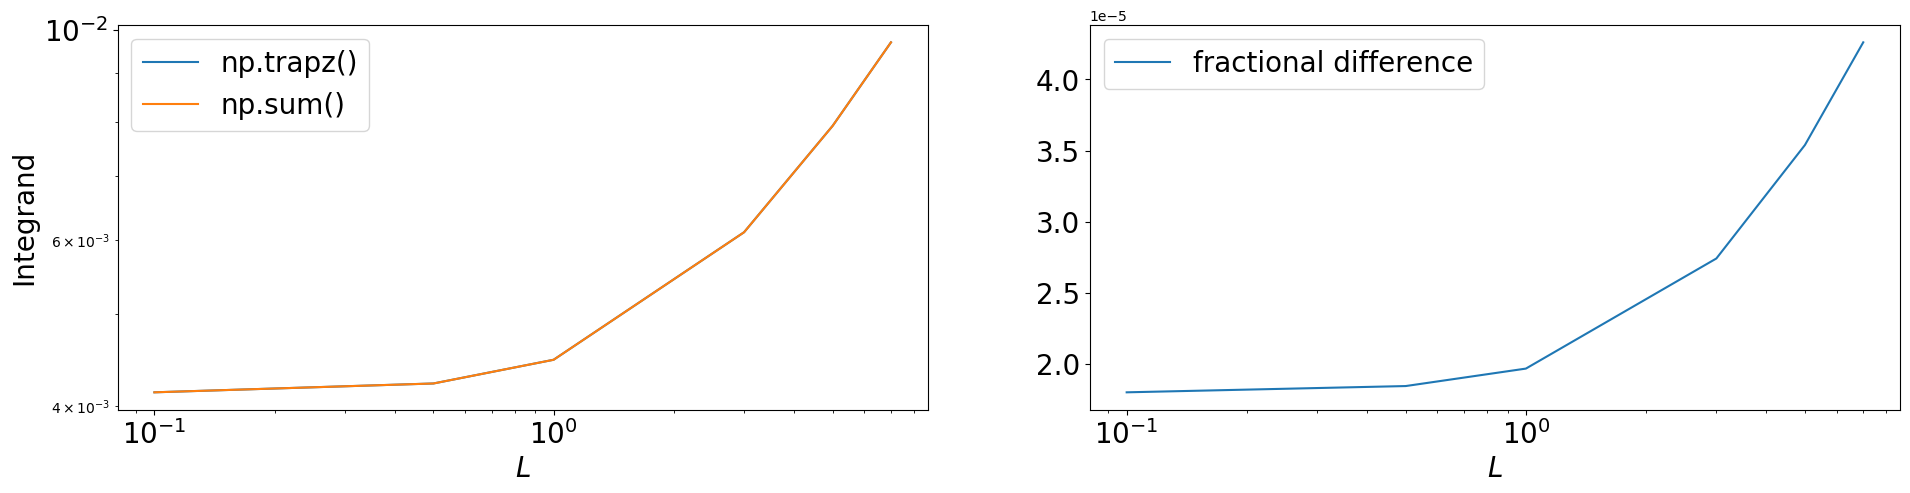

In [293]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(23,5))
ax[0].tick_params(axis='both', which='major', labelsize=20)
#plt.plot(ell, (snr_tt1-snr_tt)/snr_tt, label="MV it with lmin=10")
#plt.plot(ell, 1/2/ell)
#plt.plot(ell, (snr_tt1-snr_tt), label="MV it with lmin=10")
ax[0].plot(nlev_t, inv_snr_qe_tt, label="np.trapz()")
ax[0].plot(nlev_t, inv_snr_qe_tt1, label="np.sum()")
ax[0].set_xscale("log")
ax[0].set_yscale("log")
ax[0].set_xlabel(r'$L$', fontsize=20)
ax[0].set_ylabel(r'Integrand', fontsize=20)
ax[0].legend(fontsize=20)


ax[1].plot(nlev_t, (inv_snr_qe_tt-inv_snr_qe_tt1)/inv_snr_qe_tt, label="fractional difference")
ax[1].set_xscale("log")
#ax[1].set_yscale("log")
ax[1].set_xlabel(r'$L$', fontsize=20)
ax[1].tick_params(axis='both', which='major', labelsize=20)
#ax[1].set_ylabel(r'$L \kappa_L^2 / N_L$')
ax[1].legend(fontsize=20)

# Difference in SNR due to using flat sky and curved sky integrand

In [294]:
k = 'ptt'
itmax = 10
N_clusters = 100000
M200= 2*1e14
z = 0.7
kappa0 = haloprofile.get_kappa0(M200, z)
#nlev_t = np.array([1,2,3,4,5])
nlev_t = np.array([0.1,0.5,1,3,5,7])
nlev_p = nlev_t*np.sqrt(2)
beam_fwhm_amin = 1.0
lmax=8000
ell = np.arange(lmin_cmb,lmax+1)
kappa_ell = kappa_l[ell]


inv_snr_qe_tt_ = []
inv_snr_qe_tt_1 = []
for i in tqdm(range(len(nlev_t))):
    #fn_n0 = f'N0s_it{itmax}_{k}'
    #if not cacher.is_cached(fn_n0):
    N0s, N0s_curl = n0s.get_N0(beam_fwhm_amin, nlev_t[i], nlev_p[i], lmax_CMB=lmax_cmb, lmin_CMB=lmin_cmb, lmax_out=lmax, cls_len=cls_len_fid, cls_weight=cls_len_fid)
    NL = {}
    NL['ptt'] = N0s['ptt'] + cpp_fid
    
    #snr_tt = (2*ell + 1)*(kappa_ell/kappa0)**2/(NL["ptt"][ell]*pp_to_kk(ell))/(4 * np.pi)
    #snr_tt[0] = 0
    #sigma_kappa0_tt = np.sqrt(1./np.trapz(snr_tt)) / kappa_0
    #inv_snr_qe_tt = np.append(inv_snr_qe_tt, sigma_kappa0_tt / np.sqrt(N_clusters))

    snr_tt = ell*(kappa_ell/kappa0)**2/(NL["ptt"][ell]*pp_to_kk(ell))/(2*np.pi)
    snr_tt1 = (2*ell + 1)*(kappa_ell/kappa0)**2/(NL["ptt"][ell]*pp_to_kk(ell))/(4 * np.pi)
    
    sigma_kappa0_tt = np.sqrt(1./np.sum(snr_tt))
    inv_snr_qe_tt_ = np.append(inv_snr_qe_tt_, sigma_kappa0_tt / kappa0 / np.sqrt(N_clusters))

    sigma_kappa0_tt = np.sqrt(1./np.sum(snr_tt1))
    inv_snr_qe_tt_1 = np.append(inv_snr_qe_tt_1, sigma_kappa0_tt / kappa0 / np.sqrt(N_clusters))

100%|██████████| 6/6 [05:34<00:00, 55.74s/it]


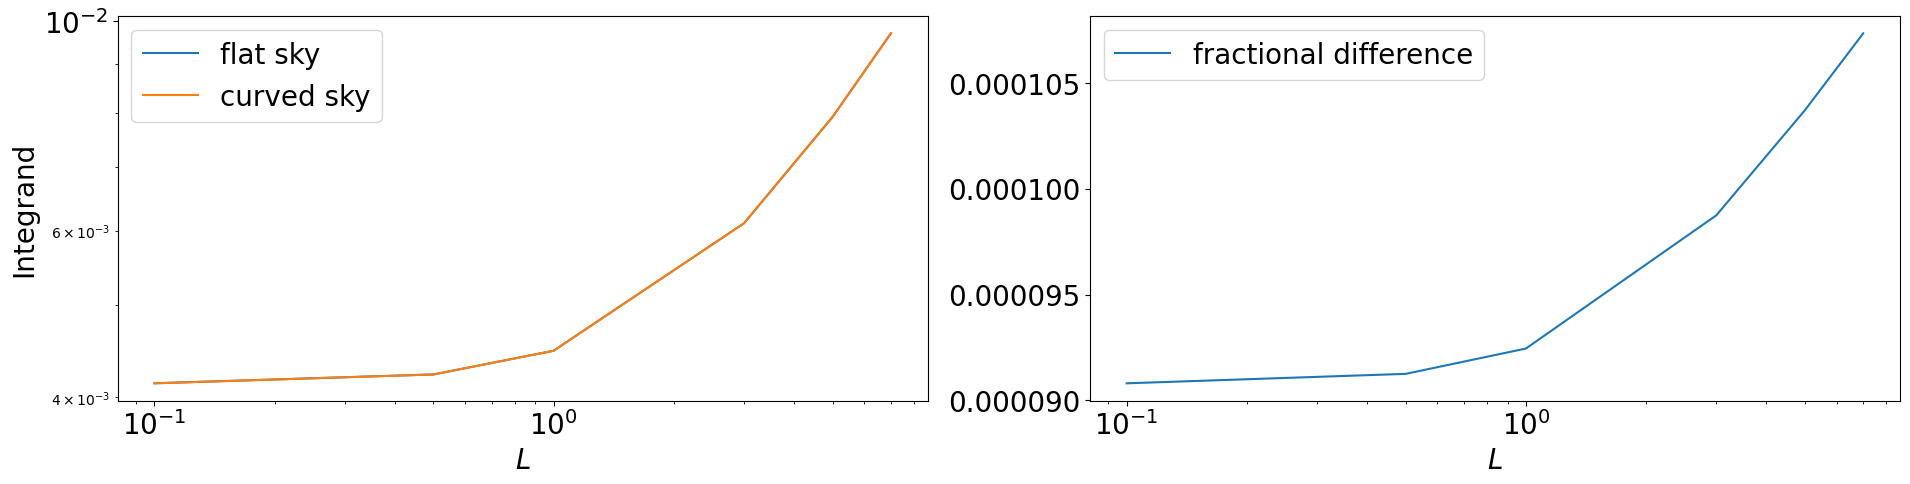

In [296]:

fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(23,5))
ax[0].tick_params(axis='both', which='major', labelsize=20)
#plt.plot(ell, (snr_tt1-snr_tt)/snr_tt, label="MV it with lmin=10")
#plt.plot(ell, 1/2/ell)
#plt.plot(ell, (snr_tt1-snr_tt), label="MV it with lmin=10")
ax[0].plot(nlev_t, inv_snr_qe_tt_, label="flat sky")
ax[0].plot(nlev_t, inv_snr_qe_tt_1, label="curved sky")
ax[0].set_xscale("log")
ax[0].set_yscale("log")
ax[0].set_xlabel(r'$L$', fontsize=20)
ax[0].set_ylabel(r'Integrand', fontsize=20)
ax[0].legend(fontsize=20)


ax[1].plot(nlev_t, (inv_snr_qe_tt_-inv_snr_qe_tt_1)/inv_snr_qe_tt_, label="fractional difference")
ax[1].set_xscale("log")
#ax[1].set_yscale("log")
ax[1].set_xlabel(r'$L$', fontsize=20)
ax[1].tick_params(axis='both', which='major', labelsize=20)
#ax[1].set_ylabel(r'$L \kappa_L^2 / N_L$')
ax[1].legend(fontsize=20)

In [203]:
k = 'ptt'
itmax = 10
N_clusters = 100000
M200= 2*1e14
z = 0.7
kappa0 = haloprofile.get_kappa0(M200, z)
#nlev_t = np.array([1,2,3,4,5])
nlev_t = np.array([0.1,0.5,1,3,5,7])
nlev_p = nlev_t*np.sqrt(2)
beam_fwhm_amin = 1.0
lmax=8000
ell = np.arange(lmin_cmb,lmax+1)
kappa_ell = kappa_l[ell]


inv_snr_qe_tt_lmin0 = []
inv_snr_qe_tt_lmin1000 = []
inv_snr_qe_tt_analft_lmin1000 = []
inv_snr_qe_pp_lmin0 = []
inv_snr_qe_pp_lmin1000 = []
inv_snr_qe_pp_analft_lmin1000 = []
inv_snr_qe_mv_lmin0 = []
inv_snr_qe_mv_lmin1000 = []
inv_snr_qe_mv_analft_lmin1000 = []
for i in tqdm(range(len(nlev_t))):
    #fn_n0 = f'N0s_it{itmax}_{k}'
    #if not cacher.is_cached(fn_n0):
    N0s, N0s_curl = n0s.get_N0(beam_fwhm_amin, nlev_t[i], nlev_p[i], lmax_CMB=lmax_cmb, lmin_CMB=lmin_cmb, lmax_out=lmax, cls_len=cls_len_fid, cls_weight=cls_len_fid)
    NL = {}
    NL['ptt'] = N0s['ptt'] + cpp_fid
    NL['p_p'] = N0s['p_p'] + cpp_fid
    NL['p'] = N0s['p'] + cpp_fid
    
    ell = np.arange(1,lmax+1)
    kappa_ell = kappa_l[ell]    
    snr_tt = (2*ell + 1)*(kappa_ell/kappa0)**2/(NL["ptt"][ell]*pp_to_kk(ell))/(4 * np.pi)
    sigma_kappa0_tt = np.sqrt(1./np.sum(snr_tt))
    inv_snr_qe_tt_lmin0 = np.append(inv_snr_qe_tt_lmin0, sigma_kappa0_tt / kappa0 / np.sqrt(N_clusters))
    snr_pp = (2*ell + 1)*(kappa_ell/kappa0)**2/(NL["p_p"][ell]*pp_to_kk(ell))/(4 * np.pi)
    sigma_kappa0_pp = np.sqrt(1./np.sum(snr_pp))
    inv_snr_qe_pp_lmin0 = np.append(inv_snr_qe_pp_lmin0, sigma_kappa0_pp / kappa0 / np.sqrt(N_clusters))
    snr_mv = (2*ell + 1)*(kappa_ell/kappa0)**2/(NL["p"][ell]*pp_to_kk(ell))/(4 * np.pi)
    sigma_kappa0_mv = np.sqrt(1./np.sum(snr_mv))
    inv_snr_qe_mv_lmin0 = np.append(inv_snr_qe_mv_lmin0, sigma_kappa0_mv / kappa0 / np.sqrt(N_clusters))



    ell = np.arange(lmin_cmb,lmax+1)
    kappa_ell = kappa_l[ell]    
    snr_tt = (2*ell + 1)*(kappa_ell/kappa0)**2/(NL["ptt"][ell]*pp_to_kk(ell))/(4 * np.pi)
    sigma_kappa0_tt = np.sqrt(1./np.sum(snr_tt))
    inv_snr_qe_tt_lmin1000 = np.append(inv_snr_qe_tt_lmin1000, sigma_kappa0_tt / kappa0 / np.sqrt(N_clusters))
    snr_pp = (2*ell + 1)*(kappa_ell/kappa0)**2/(NL["p_p"][ell]*pp_to_kk(ell))/(4 * np.pi)
    sigma_kappa0_pp = np.sqrt(1./np.sum(snr_pp))
    inv_snr_qe_pp_lmin1000 = np.append(inv_snr_qe_pp_lmin1000, sigma_kappa0_pp / kappa0 / np.sqrt(N_clusters))
    snr_mv = (2*ell + 1)*(kappa_ell/kappa0)**2/(NL["p"][ell]*pp_to_kk(ell))/(4 * np.pi)
    sigma_kappa0_mv = np.sqrt(1./np.sum(snr_mv))
    inv_snr_qe_mv_lmin1000 = np.append(inv_snr_qe_mv_lmin1000, sigma_kappa0_mv / kappa0 / np.sqrt(N_clusters))



    ell = np.arange(lmin_cmb,lmax+1)
    kappa_ell = ft_analytical[ell]   
    snr_tt = (2*ell + 1)*(kappa_ell/kappa0)**2/(NL["ptt"][ell]*pp_to_kk(ell))/(4 * np.pi)
    sigma_kappa0_tt = np.sqrt(1./np.sum(snr_tt))
    inv_snr_qe_tt_analft_lmin1000 = np.append(inv_snr_qe_tt_analft_lmin1000, sigma_kappa0_tt / kappa0 / np.sqrt(N_clusters))
    snr_pp = (2*ell + 1)*(kappa_ell/kappa0)**2/(NL["p_p"][ell]*pp_to_kk(ell))/(4 * np.pi)
    sigma_kappa0_pp = np.sqrt(1./np.sum(snr_pp))
    inv_snr_qe_pp_analft_lmin1000 = np.append(inv_snr_qe_pp_analft_lmin1000, sigma_kappa0_pp / kappa0 / np.sqrt(N_clusters))
    snr_mv = (2*ell + 1)*(kappa_ell/kappa0)**2/(NL["p"][ell]*pp_to_kk(ell))/(4 * np.pi)
    sigma_kappa0_mv = np.sqrt(1./np.sum(snr_mv))
    inv_snr_qe_mv_analft_lmin1000 = np.append(inv_snr_qe_mv_analft_lmin1000, sigma_kappa0_mv / kappa0 / np.sqrt(N_clusters))



100%|██████████| 6/6 [04:26<00:00, 44.35s/it]


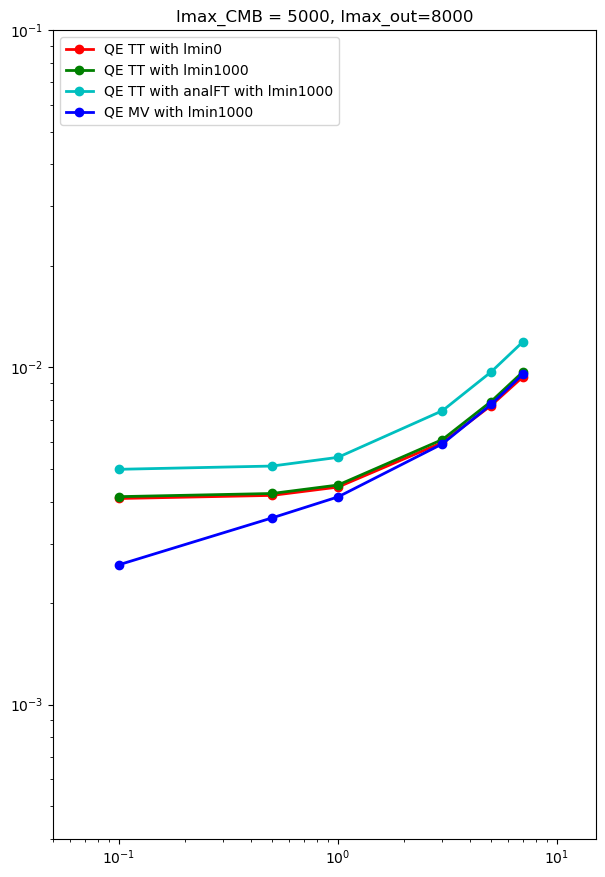

In [207]:
plt.figure(figsize=(7,10.5))

plt.plot(nlev_t, inv_snr_qe_tt_lmin0, c="r", ls="-",marker='o', lw=2, label="QE TT with lmin0")
plt.plot(nlev_t, inv_snr_qe_tt_lmin1000, c="g", ls="-",marker='o', lw=2, label="QE TT with lmin1000")
plt.plot(nlev_t, inv_snr_qe_tt_analft_lmin1000, c="c", ls="-",marker='o', lw=2, label="QE TT with analFT with lmin1000")

#plt.plot(nlev_t, inv_snr_qe_pp_lmin0, c="b", ls="-",marker='o', lw=2, label="QE PP with lmin0")
#plt.plot(nlev_t, inv_snr_qe_pp_lmin1000, c="y", ls="-",marker='o', lw=2, label="QE PP with lmin1000")
#plt.plot(nlev_t, inv_snr_qe_pp_analft_lmin1000, c="orange", ls="-",marker='o', lw=2, label="QE PP with analFT with lmin1000")

#plt.plot(nlev_t, inv_snr_qe_mv_lmin0, c="y", ls="-",marker='o', lw=2, label="QE MV with lmin0")
plt.plot(nlev_t, inv_snr_qe_mv_lmin1000, c="b", ls="-",marker='o', lw=2, label="QE MV with lmin1000")
#plt.plot(nlev_t, inv_snr_qe_mv_analft_lmin1000, c="orange", ls="-",marker='o', lw=2, label="QE MV with analFT with lmin1000")

ax = plt.gca()
ax.set_xlim([0.05, 15])
ax.set_ylim([0.0004, 0.1])
plt.yscale("log")
plt.xscale("log")
#plt.xlabel(r"$\Delta_T = \Delta_P/\sqrt{2}$ ($\mu K$ - arcmin)")
#plt.ylabel("Inverse SNR")
plt.legend(loc="upper left", fontsize=10)
plt.title("lmax_CMB = 5000, lmax_out=8000")
plt.savefig("result_srini_lmaxcmb5k_lmincmb1k_tt.png", transparent=True)
#plt.close()

In [297]:
from IPython.display import Image
#Image(url="../../compare_srini/compare_right_tt_.png", width=400, height=400)

In [222]:
itmax = 10
N_clusters = 100000
M200= 2*1e14
z = 0.7
kappa0 = haloprofile.get_kappa0(M200, z)
#nlev_t = np.array([1,2,3,4,5])
nlev_t = np.array([0.1,0.5,1,3,5,7])
nlev_p = nlev_t*np.sqrt(2)
beam_fwhm_amin = 1.0
lmax=8000
ell = np.arange(lmin_cmb,lmax+1)
kappa_ell = kappa_l[ell]



inv_snr_qe_tt_lmin1000_it = []
inv_snr_qe_pp_lmin1000_it = []
inv_snr_qe_mv_lmin1000_it = []

for i in tqdm(range(len(nlev_t))):
    #fn_n0 = f'N0s_it{itmax}_{k}'
    #if not cacher.is_cached(fn_n0):
    NL= {}
    for k in ['ptt', 'p_p', 'p']:
        N0s_it, _ = n0s.get_N0_iter(k, nlev_t[i], nlev_p[i], beam_fwhm_amin, cls_unl_fid,  lmin_cmb=lmin_cmb, lmax_cmb=lmax_cmb, itermax=itmax, lmax_qlm=lmax)
        NL[k] = (N0s_it[-1] + cpp_fid)
    

    ell = np.arange(lmin_cmb,lmax+1)
    kappa_ell = kappa_l[ell]    
    snr_tt = (2*ell + 1)*(kappa_ell/kappa0)**2/(NL["ptt"][ell]*pp_to_kk(ell))/(4 * np.pi)
    sigma_kappa0_tt = np.sqrt(1./np.sum(snr_tt))
    inv_snr_qe_tt_lmin1000_it = np.append(inv_snr_qe_tt_lmin1000_it, sigma_kappa0_tt / kappa0 / np.sqrt(N_clusters))
    snr_pp = (2*ell + 1)*(kappa_ell/kappa0)**2/(NL["p_p"][ell]*pp_to_kk(ell))/(4 * np.pi)
    sigma_kappa0_pp = np.sqrt(1./np.sum(snr_pp))
    inv_snr_qe_pp_lmin1000_it = np.append(inv_snr_qe_pp_lmin1000_it, sigma_kappa0_pp / kappa0 / np.sqrt(N_clusters))
    snr_mv = (2*ell + 1)*(kappa_ell/kappa0)**2/(NL["p"][ell]*pp_to_kk(ell))/(4 * np.pi)
    sigma_kappa0_mv = np.sqrt(1./np.sum(snr_mv))
    inv_snr_qe_mv_lmin1000_it = np.append(inv_snr_qe_mv_lmin1000_it, sigma_kappa0_mv / kappa0 / np.sqrt(N_clusters))


  0%|          | 0/6 [00:00<?, ?it/s]

 [00:00:15]  ---------> 90%
 [00:02:20]  ---------> 90%
 [00:10:13]  ---------> 90%


 17%|█▋        | 1/6 [12:48<1:04:03, 768.71s/it]

 [00:00:13]  ---------> 90%
 [00:02:26]  ---------> 90%
 [00:10:00]  ---------> 90%


 33%|███▎      | 2/6 [25:29<51:04, 766.23s/it]  

 [00:00:13]  ---------> 90%
 [00:02:13]  ---------> 90%
 [00:09:46]  ---------> 90%


 50%|█████     | 3/6 [37:41<37:48, 756.20s/it]

 [00:00:15]  ---------> 90%
 [00:02:11]  ---------> 90%
 [00:09:55]  ---------> 90%


 67%|██████▋   | 4/6 [50:04<25:04, 752.21s/it]

 [00:00:14]  ---------> 90%
 [00:02:25]  ---------> 90%
 [00:47:31]  ---------> 90%


 83%|████████▎ | 5/6 [1:40:16<23:49, 1429.99s/it]

 [00:00:15]  ---------> 90%
 [00:02:38]  ---------> 90%
 [00:11:57]  ---------> 90%


100%|██████████| 6/6 [1:55:07<00:00, 1151.29s/it]


Text(0.5, 1.0, 'lmax_CMB = 5000, lmax_out=8000')

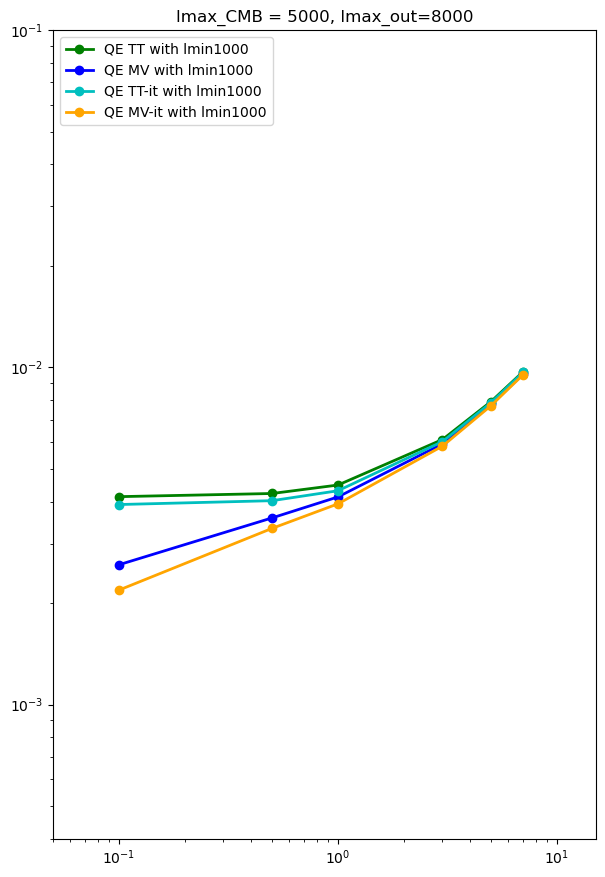

In [301]:
plt.figure(figsize=(7,10.5))

plt.plot(nlev_t, inv_snr_qe_tt_lmin1000, c="g", ls="-",marker='o', lw=2, label="QE TT with lmin1000")

#plt.plot(nlev_t, inv_snr_qe_mv_lmin0, c="y", ls="-",marker='o', lw=2, label="QE MV with lmin0")
plt.plot(nlev_t, inv_snr_qe_mv_lmin1000, c="b", ls="-",marker='o', lw=2, label="QE MV with lmin1000")
#plt.plot(nlev_t, inv_snr_qe_mv_analft_lmin1000, c="orange", ls="-",marker='o', lw=2, label="QE MV with analFT with lmin1000")
plt.plot(nlev_t, inv_snr_qe_tt_lmin1000_it, c="c", ls="-",marker='o', lw=2, label="QE TT-it with lmin1000")
plt.plot(nlev_t, inv_snr_qe_mv_lmin1000_it, c="orange", ls="-",marker='o', lw=2, label="QE MV-it with lmin1000")

ax = plt.gca()
ax.set_xlim([0.05, 15])
ax.set_ylim([0.0004, 0.1])
plt.yscale("log")
plt.xscale("log")
#plt.xlabel(r"$\Delta_T = \Delta_P/\sqrt{2}$ ($\mu K$ - arcmin)")
#plt.ylabel("Inverse SNR")
plt.legend(loc="upper left", fontsize=10)
plt.title("lmax_CMB = 5000, lmax_out=8000")
#plt.savefig("result_srini_lmaxcmb5k_lmincmb1k_iterative.png", transparent=True)
#plt.close()

In [298]:
#Image(url="../../compare_srini/compare_right_tt_mv_iterative.png", width=400, height=400)

In [214]:
cls_len = cls_len_fid
cls_unl = cls_unl_fid
cls_weight = cls_len_fid
k, ksource = 'ptt', 'p'
N_clusters = 1e5

lmin_ivf, lmax_ivf, lmax_qlm = 1000, 5000, lmax
transf = hp.gauss_beam(1. / 180 / 60 * np.pi, lmax=lmax_ivf)
#nlevts = np.logspace(-1, 1, 10)
nlevts = np.array([0.1,0.5,1,3,5,7])
sigma = {'ptt':np.zeros(nlevts.size), 'p_p':np.zeros(nlevts.size)}
kSZ_Dl = 2.9 # uK^2
wCkk = True
kSZ_Cl = kSZ_Dl * utils.cli(np.arange(lmax_ivf + 1) * np.arange(1, lmax_ivf + 2) / 2 / np.pi)
for i, nlevt in utils.enumerate_progress(nlevts):
    fals = {'tt': cli(cls_len['tt'][:lmax_ivf + 1] + (nlevt / 180 / 60 * np.pi) ** 2 / transf ** 2) + kSZ_Cl / transf ** 2}
    fals['tt'][:lmin_ivf] *= 0.
    fals['ee'] = cli(cls_len['ee'][:lmax_ivf + 1] + (nlevt * np.sqrt(2.) / 180 / 60 * np.pi) ** 2 / transf ** 2)
    fals['ee'][:lmin_ivf] *= 0.
    fals['bb'] = cli(cls_len['bb'][:lmax_ivf + 1] + (nlevt * np.sqrt(2.) / 180 / 60 * np.pi) ** 2 / transf ** 2)
    fals['bb'][:lmin_ivf] *= 0.
    for k in ['ptt', 'p_p']:
        N0_pp = utils.cli(qresp.get_response(k, lmax_ivf, ksource, cls_weight, cls_len, fals, lmax_qlm=lmax_qlm)[0])
        N0_pp += wCkk * cls_unl['pp'][:lmax_qlm+1]
        N0_kk = N0_pp * np.arange(lmax_qlm + 1, dtype=float) ** 2 * np.arange(1, lmax_qlm + 2, dtype=float) ** 2 * 0.25
        ls = np.arange(lmin_ivf, lmax_qlm + 1)
        F_intg =  (2 * ls  + 1) * (kappa_l[ls] / kappa_0) ** 2 / N0_kk[ls] / (4 * np.pi)
        sigma[k][i] = np.sqrt(1./np.sum(F_intg)) / kappa_0 / np.sqrt(N_clusters)



 [00:00:29]  --------> 83%


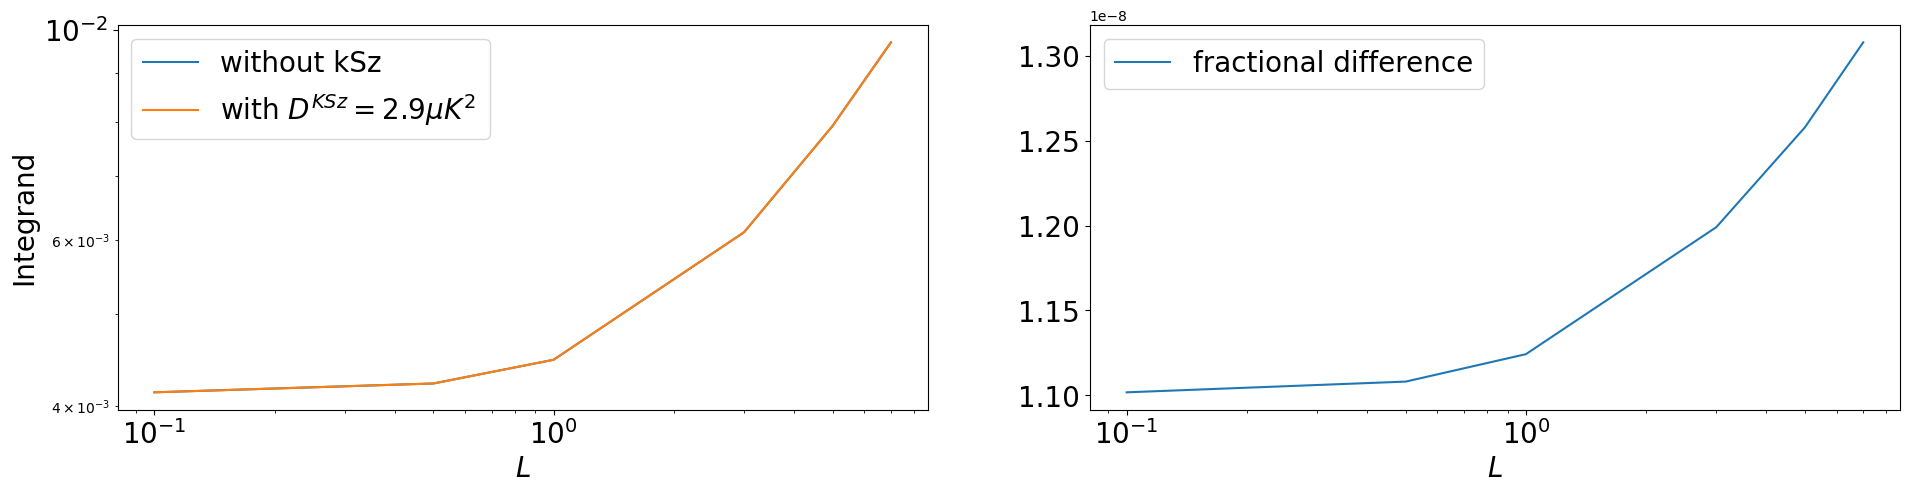

In [277]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(23,5))
ax[0].tick_params(axis='both', which='major', labelsize=20)
#plt.plot(ell, (snr_tt1-snr_tt)/snr_tt, label="MV it with lmin=10")
#plt.plot(ell, 1/2/ell)
#plt.plot(ell, (snr_tt1-snr_tt), label="MV it with lmin=10")
ax[0].plot(nlev_t, inv_snr_qe_tt_lmin1000, label="without kSz")
ax[0].plot(nlev_t, sigma['ptt'], label="with $D^{KSz} = 2.9\mu K^2$ ")
ax[0].set_xscale("log")
ax[0].set_yscale("log")
ax[0].set_xlabel(r'$L$', fontsize=20)
ax[0].set_ylabel(r'Integrand', fontsize=20)
ax[0].legend(fontsize=20)


ax[1].plot(nlev_t, (inv_snr_qe_tt_lmin1000-sigma['ptt'])/inv_snr_qe_tt_lmin1000, label="fractional difference")
ax[1].set_xscale("log")
#ax[1].set_yscale("log")
ax[1].set_xlabel(r'$L$', fontsize=20)
ax[1].tick_params(axis='both', which='major', labelsize=20)
#ax[1].set_ylabel(r'$L \kappa_L^2 / N_L$')
ax[1].legend(fontsize=20)

In [112]:
nlevt=1
N0s1, N0s_curl = n0s.get_N0(beam_fwhm=1, nlev_t=nlevt, nlev_p=nlevt*np.sqrt(2), lmax_CMB=3000, lmin_CMB=10, lmax_out=6000, cls_len=cls_len_fid, cls_weight=cls_len_fid)
N0s2, N0s_curl = n0s.get_N0(beam_fwhm=1, nlev_t=nlevt, nlev_p=nlevt*np.sqrt(2), lmax_CMB=5000, lmin_CMB=10, lmax_out=6000, cls_len=cls_len_fid, cls_weight=cls_len_fid)

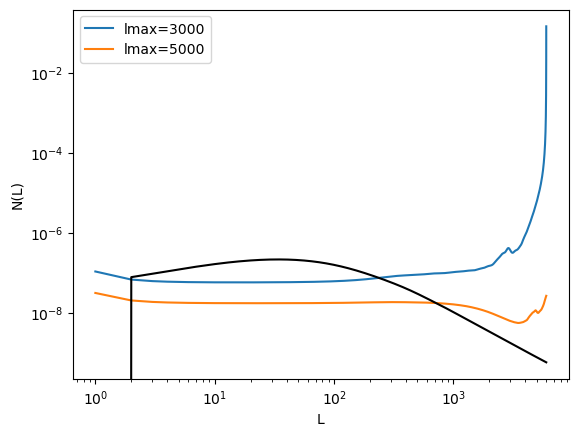

In [116]:
ell = np.arange(1,6001)
plt.plot(ell, pp_to_kk(ell)*N0s1["ptt"][ell], label='lmax=3000')
plt.plot(ell, pp_to_kk(ell)*N0s2["ptt"][ell], label='lmax=5000')
plt.plot(ell, pp_to_kk(ell)*cpp_fid[ell], c='k')
plt.loglog()

plt.xlabel('L')
plt.ylabel('N(L)')
plt.legend()